In [2]:
import numpy as np
import pandas as pd
import os
from scipy.integrate import quad_vec
import matplotlib.pyplot as plt
CurrentPath = os.getcwd()
sndata = pd.read_csv(CurrentPath + '/2025/parsonage.txt', sep = ' ', engine='python')

In [3]:
# observed data
mb = sndata['mb'].values
dmb = sndata['dmb'].values
z = sndata['zcmb'].values

In [12]:
dmb[3]

0.116

# 1. SN data

## 1-1. Flat LCDM

In [14]:
def E_inverse_flat(z, Omega_m): # return 1/E(z) = H0/H(z)
    Omega_L = 1 - Omega_m
    E = np.sqrt(Omega_m*(1+z)**3 + Omega_L)
    return 1/E

def Other_stuff_flat(z, parm):
    H0, Omegam = parm
    integral = np.array([quad_vec(E_inverse_flat, 0,zval, args=(Omegam))[0] for zval in z])
    return integral

def A(func,mb, dmb,z, parm):
    ndata = mb.size
    A = 1/ndata*np.sum(dmb**2)*np.sum((mb - func(z,parm))/(dmb**2))
    return A

from tqdm import tqdm

# 1. make a code that accounts for a prior
def ln_prior(min,max):
    volume = np.prod(np.abs(min - max)) # volume of the prior
    return np.log(1/volume)

def Loglikelihood(func, parm,SNdata): # return Loglikelihood = -chisq, parm[0] = H0, parm[1] = Omegam, parm[2] = Omegalamb
    mb = SNdata['mb'].values
    dmb = SNdata['dmb'].values
    z = SNdata['zcmb'].values
    m_z = A(func, mb,dmb, z, parm) + func(z, parm) # m_z = A + integral
    diff = (mb - m_z)**2
    chisq = np.sum(diff/dmb**2)
    return -chisq

def ln_f(func, parm,SNdata, prior, lnprior): # return total Loglikelihood
    bool = np.all((prior[0] <= parm) & (parm <= prior[1]))
    if bool == True:
        return lnprior + Loglikelihood(func, parm, SNdata) # param[0] = H0, param[1] = Omegam, param[2] = Omegalamb
    else:
        return -np.inf

def Markov(func, paramk,paramkp1,SNdata, prior, lnprior):
    minuschisqk = ln_f(func, paramk, SNdata, prior, lnprior)
    minuschisqkp1 = ln_f(func, paramkp1, SNdata, prior, lnprior)
    lnr = np.log(np.random.uniform(0.,1.))

    if minuschisqkp1 - minuschisqk > lnr:
#        print(f"param0 = {paramk}, paramkp1 = {paramkp1}, \n chisq0 = {minuschisqk}, chisqkp1 = {minuschisqkp1}, lnr = {lnr}, moved : True")
        return paramkp1, minuschisqkp1
    else:
#        print(f"param0 = {paramk}, paramkp1 = {paramkp1}, \n chisq0 = {minuschisqk}, chisqkp1 = {minuschisqkp1}, lnr = {lnr}, moved : False")
        return paramk, minuschisqk

def MCMC(func, paraminit,SNdata, nstep,normal_vec,prior): # param0 = [H0, Omegam, Omegalamb]
    lnprior = ln_prior(prior[0], prior[1]) # calculate the prior volume likelihood
    param0 = paraminit
    arr = np.zeros((len(param0) + 1,nstep))
    stepsize = normal_vec
    for k in tqdm(range(nstep)):
        paramkp1 = np.array(param0 + np.random.normal(0,stepsize))
        param0, loglikelihood = Markov(func, param0, paramkp1,SNdata, prior, lnprior) #loglikelihood = -chisq
        col = np.hstack((param0, loglikelihood))
        arr[:,k] = col
    return arr

In [15]:
Prior1 = np.array([[4.66594018,0], [36.39070654, 1]])

In [22]:
normal_vec = np.array([2.16656036e-01, 8.47071452e-06])
std = np.array([0.25058526, 0.001])
paraminit = np.array([17.559485514552893, 1.5139296621150994e-08]) + np.random.normal(0,std)
nstep = int(1000)
MCMC_test = MCMC(Other_stuff_flat, paraminit, sndata, nstep, normal_vec, Prior1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:17<00:00,  3.15it/s]


accept_ratio = 0.91125
Best_fit = Omega_m : 1.1298194635719206e-07, Hubble_constant : 9.60621861813521
std = [7.09838952e-01 5.54561520e-04]


Text(0.5, 1.0, 'MCMC result for Flat LCDM')

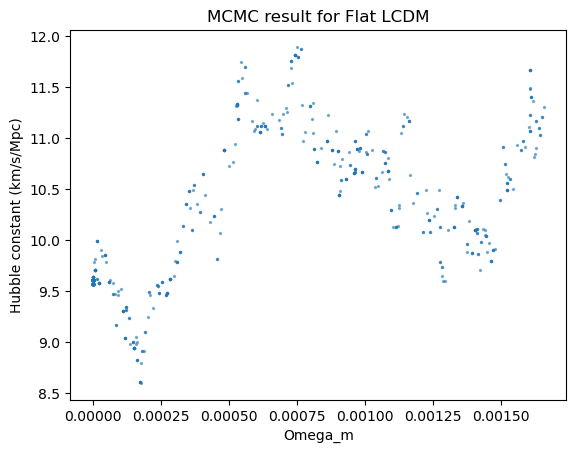

In [23]:
MCMC_test = MCMC_test[:,200:]
accept_ratio = np.unique(MCMC_test).shape[0] / (nstep-200)
Best_fit = MCMC_test[:,np.argmax(MCMC_test[-1])]
std = np.std(MCMC_test[0:2], axis=1)
print(f'accept_ratio = {accept_ratio}')
print(f'Best_fit = Omega_m : {Best_fit[1]}, Hubble_constant : {Best_fit[0]}')
print(f'std = {std}')
plt.scatter(MCMC_test[1], MCMC_test[0], s=2, alpha=0.5)
plt.xlabel('Omega_m')
plt.ylabel('Hubble constant (km/s/Mpc)')
plt.title('MCMC result for Flat LCDM')